In [218]:
from spatialdata import SpatialData
from spatialdata.models import Image2DModel, Labels2DModel, ShapesModel, TableModel
from spatialdata.transformations.transformations import Identity, Scale
from xarray import DataArray
from anndata import AnnData, read_zarr
from tifffile import imread
import numpy as np
import scanpy as sc

In [2]:
adata = read_zarr("151673.adata.zarr")

In [3]:
adata

AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_k24', 'SNN_k50_k25', 'SNN_k50_k26', 'SNN_k50_k27', 'SNN_k50_k28', 'GraphBased', 'Maynard', 'Martinowich', 'Layer', 'layer_guess', 'layer_guess_reordered', 'layer_guess_reordered_short', 'expr_chrM', 'expr_chrM_ratio', 'SpatialDE_PCA', 'SpatialDE_pool_PCA', 'HVG_PCA', 'pseudobulk_PCA', 'markers_PCA', 'SpatialDE_UMAP', 'SpatialDE_pool_UMAP', 'HVG_UMAP', 'pseudobulk_UMAP', 'markers_UMAP', 'SpatialDE_PCA_spatial', 'SpatialD

In [184]:
import matplotlib.pyplot as plt

import shapely.geometry as geometry
from shapely.ops import cascaded_union, polygonize
from descartes import PolygonPatch
from scipy.spatial import Delaunay
import numpy as np
import math
import skimage as ski

In [28]:
# Reference: https://gist.github.com/jclosure/d93f39a6c7b1f24f8b92252800182889
def alpha_shape(points, alpha):
    """
    Compute the alpha shape (concave hull) of a set of points.

    @param points: Iterable container of points.
    @param alpha: alpha value to influence the gooeyness of the border. Smaller
                  numbers don't fall inward as much as larger numbers. Too large,
                  and you lose everything!
    """
    if len(points) < 4:
        # When you have a triangle, there is no sense in computing an alpha
        # shape.
        return geometry.MultiPoint(list(points)).convex_hull

    def add_edge(edges, edge_points, coords, i, j):
        """Add a line between the i-th and j-th points, if not in the list already"""
        if (i, j) in edges or (j, i) in edges:
            # already added
            return
        edges.add( (i, j) )
        edge_points.append(coords[ [i, j] ])

    coords = np.array(points)

    tri = Delaunay(coords)
    edges = set()
    edge_points = []
    # loop over triangles:
    # ia, ib, ic = indices of corner points of the triangle
    for ia, ib, ic in tri.simplices:
        pa = coords[ia]
        pb = coords[ib]
        pc = coords[ic]

        # Lengths of sides of triangle
        a = math.sqrt((pa[0]-pb[0])**2 + (pa[1]-pb[1])**2)
        b = math.sqrt((pb[0]-pc[0])**2 + (pb[1]-pc[1])**2)
        c = math.sqrt((pc[0]-pa[0])**2 + (pc[1]-pa[1])**2)

        # Semiperimeter of triangle
        s = (a + b + c)/2.0

        # Area of triangle by Heron's formula
        area = math.sqrt(s*(s-a)*(s-b)*(s-c))
        circum_r = a*b*c/(4.0*area)

        # Here's the radius filter.
        #print circum_r
        if circum_r < 1.0/alpha:
            add_edge(edges, edge_points, coords, ia, ib)
            add_edge(edges, edge_points, coords, ib, ic)
            add_edge(edges, edge_points, coords, ic, ia)

    m = geometry.MultiLineString(edge_points)
    triangles = list(polygonize(m))
    return cascaded_union(triangles), edge_points

In [29]:
layers = adata.obs['layer_manual'].unique().tolist()

In [177]:
layer_to_vertices = {}
for layer in layers:
    layer_adata = adata[adata.obs['layer_manual'] == layer, :].copy()

    x_noise = np.random.uniform(low=0, high=0.01, size=layer_adata.shape[0])
    y_noise = np.random.uniform(low=0, high=0.01, size=layer_adata.shape[0])

    x = layer_adata.obs['imagecol'].values + x_noise
    y = layer_adata.obs['imagerow'].values + y_noise
    
    points = [ list(t) for t in list(zip(x, y)) ]
    point_collection = geometry.MultiPoint(points)
    polygon = point_collection.envelope

    if len(points) > 0:
        alpha = 0.05
        concave_hull, edge_points = alpha_shape(points, alpha=alpha)
        layer_to_vertices[layer] = concave_hull

/var/folders/36/83j6x3ln225bvbpk1_vdzrm00000gn/T/ipykernel_62661/439151618.py:56: ShapelyDeprecationWarning: The 'cascaded_union()' function is deprecated. Use 'unary_union()' instead.
  return cascaded_union(triangles), edge_points
/Users/mkeller/software/miniconda3/envs/vitessce-python-demos/lib/python3.10/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [165]:
np.max(adata.obs['imagerow'].values)

521.332151168

In [166]:
np.max(adata.obs['imagecol'].values)

497.839801124

In [167]:
layers

['Layer_3', 'Layer_1', 'WM', 'Layer_5', 'Layer_6', 'Layer_2', 'Layer_4', nan]

In [183]:
image_shape = (600, 600)

In [182]:
layer_to_mask = {}
for layer in layer_to_vertices.keys():
    try:
        layer_mask = ski.draw.polygon2mask(image_shape, layer_to_vertices[layer].exterior.coords)
    except AttributeError:
        layer_mask = np.zeros(image_shape)
        for polygon in layer_to_vertices[layer].geoms:
            layer_mask += ski.draw.polygon2mask(image_shape, polygon.exterior.coords)
    layer_to_mask[layer] = layer_mask

In [185]:
layer_keys = ['Layer_1', 'Layer_2', 'Layer_3', 'Layer_4', 'Layer_5', 'Layer_6', 'WM']

In [193]:
img_arr = np.zeros((len(layer_keys), image_shape[0], image_shape[1]))
for layer_i, layer in enumerate(layer_keys):
    img_arr[layer_i, :, :] = layer_to_mask[layer]

img_arr = img_arr.transpose((0, 2, 1))

In [194]:
img_arr.shape

(7, 600, 600)

In [273]:
# To SpatialData

coords = adata.obs[["imagecol", "imagerow"]].values
adata.obs["spot_id"] = np.arange(len(adata))

dataset_id = "visium_151673"
spot_diameter_fullres = 5.0

transform_original = Identity()
transform_hires = Scale(
    np.array([600/13332, 600/13332]),
    axes=("y", "x"),
)
shapes = {}
circles = ShapesModel.parse(
    coords,
    geometry=0,
    radius=spot_diameter_fullres / 2.0,
    index=adata.obs["spot_id"].copy(),
    transformations={
        "global": transform_original,
        "downscaled_hires": transform_hires,
    },
)
shapes[dataset_id] = circles
adata.obs["region"] = dataset_id
adata.obs["region"] = adata.obs["region"].astype("category")
table = TableModel.parse(adata, region=dataset_id, region_key="region", instance_key="spot_id")

ValueError: Either pass `region`, `region_key` and `instance_key`as arguments or have them in `adata.uns['spatialdata_attrs']`.

In [274]:
full_img_arr = imread("151673_full_image.tif").transpose((2, 0, 1))
full_img_arr.shape

(3, 13332, 13332)

In [275]:
# TODO: move this img_arr (the masks) into labels, and read in TIFF to put in images here
# Update: cannot move the label image into masks because it is more than one channel
images = {}

label_image = DataArray(img_arr, dims=("c", "y", "x"))
full_image = DataArray(full_img_arr, dims=("c", "y", "x"))
images[dataset_id + "_annotations"] = Image2DModel.parse(
    label_image,
    scale_factors=[2, 2, 2, 2],
    transformations={"global": transform_original},
)
images[dataset_id + "_full_image"] = Image2DModel.parse(
    full_image,
    scale_factors=[2, 2, 2, 2],
    transformations={"global": transform_hires},
)

In [276]:
sdata = SpatialData(images=images, shapes=shapes, table=table)

In [277]:
sdata

SpatialData object with:
├── Images
│     ├── 'visium_151673_annotations': MultiscaleSpatialImage[cyx] (7, 600, 600), (7, 300, 300), (7, 150, 150), (7, 75, 75), (7, 37, 37)
│     └── 'visium_151673_full_image': MultiscaleSpatialImage[cyx] (3, 13332, 13332), (3, 6666, 6666), (3, 3333, 3333), (3, 1666, 1666), (3, 833, 833)
├── Shapes
│     └── 'visium_151673': GeoDataFrame shape: (3639, 2) (2D shapes)
└── Table
      └── AnnData object with n_obs × n_vars = 3639 × 33538
    obs: 'barcode', 'sample_name', 'tissue', 'row', 'col', 'imagerow', 'imagecol', 'Cluster', 'height', 'width', 'sum_umi', 'sum_gene', 'subject', 'position', 'replicate', 'subject_position', 'discard', 'key', 'cell_count', 'SNN_k50_k4', 'SNN_k50_k5', 'SNN_k50_k6', 'SNN_k50_k7', 'SNN_k50_k8', 'SNN_k50_k9', 'SNN_k50_k10', 'SNN_k50_k11', 'SNN_k50_k12', 'SNN_k50_k13', 'SNN_k50_k14', 'SNN_k50_k15', 'SNN_k50_k16', 'SNN_k50_k17', 'SNN_k50_k18', 'SNN_k50_k19', 'SNN_k50_k20', 'SNN_k50_k21', 'SNN_k50_k22', 'SNN_k50_k23', 'SNN_k50_

/Users/mkeller/software/miniconda3/envs/vitessce-python-demos/lib/python3.10/site-packages/spatialdata/models/models.py:620: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(data[c]) and not data[c].cat.known:
/Users/mkeller/software/miniconda3/envs/vitessce-python-demos/lib/python3.10/site-packages/spatialdata/models/models.py:620: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(data[c]) and not data[c].cat.known:
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
/Users/mkeller/software/miniconda3/envs/vitessce-python-demos/lib/python3.10/site-packages/spatialdata/models/models.py:620: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, 

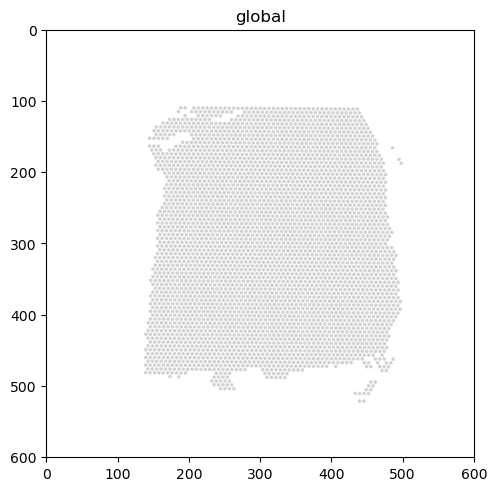

In [278]:
import spatialdata_plot

sdata.pl.render_images().pl.render_shapes().pl.show('global')

In [279]:
table.obs.region

AAACAAGTATCTCCCA-1    visium_151673
AAACAATCTACTAGCA-1    visium_151673
AAACACCAATAACTGC-1    visium_151673
AAACAGAGCGACTCCT-1    visium_151673
AAACAGCTTTCAGAAG-1    visium_151673
                          ...      
TTGTTTCACATCCAGG-1    visium_151673
TTGTTTCATTAGTCTA-1    visium_151673
TTGTTTCCATACAACT-1    visium_151673
TTGTTTGTATTACACG-1    visium_151673
TTGTTTGTGTAAATTC-1    visium_151673
Name: region, Length: 3639, dtype: category
Categories (1, object): ['visium_151673']

In [280]:
from pandas.api.types import is_categorical_dtype

In [281]:
is_categorical_dtype(adata.obs.region)

/var/folders/36/83j6x3ln225bvbpk1_vdzrm00000gn/T/ipykernel_62661/3676922336.py:1: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(adata.obs.region)


True

In [282]:
sdata.write("151673.sdata.zarr")

ValueError: The Zarr store already exists. Use `overwrite=True` to overwrite the store.